# Лабораторная работа № 3 
## Задание
Необходимо познакомиться с фреймворком машинного обучения PyTorch и выполнить три задания:

1. Обучить полносвязную нейронную сеть классификации 3 классов изображений из набора данных CIFAR100 по варианту с точностью на тестовой выборке не менее 70%.
Для задания нужно сформировать свою подвыборку CIFAR100 по варианту.
2. Преобразовать модель в ONNX и сохранить локально.
3. Протестировать обученную модель на своих изображениях.
  - Скачать каталог с html-файлом и встроить в него файл модели, обученной на ЛР.
  - Скачать картинки из интернета согласно варианту и открыть их в html по кнопке. Автоматически в скрипте масштабируется изображение.
  - Выбрать нужные классы для готовой модели. Проверить на устойчивость полносвязную модель, двигая картинку.

### Варианты для Задания
Вы должны использовать следующие классы из CIFAR100:

Номер группы

In [4]:
GROUP = 6

Номер варианта
Номер варианта + 30

In [5]:
VARIANT = 10

In [6]:
LABELS = [GROUP, VARIANT, VARIANT + 30]

In [7]:
from torchvision.datasets import CIFAR100

## Загружаем тестовую и обучающую выборку CIFAR100

In [8]:
from torchvision.transforms import ToTensor

dataset_settings = {
    'root': 'data/cifar100',
    'transform': ToTensor(),
    'download': True,
}

train_data = CIFAR100(train=True, **dataset_settings)

test_data = CIFAR100(train=False, **dataset_settings)

Files already downloaded and verified
Files already downloaded and verified


Формируем подвыборку согласно варианту.

In [9]:
import torch
import numpy as np
from torch.utils.data import Subset, TensorDataset

def make_subset(dataset: TensorDataset, labels: list[np.integer]) -> Subset:
    """
    Создает подвыборку с задаными метками класса.

    :param dataset: Набор данных.
    :type dataset: TensorDataset (или любой другой тип датасета с совместимым форматом)
    :param labels: Метки класса.
    :type labels: list[np.integer]
    :return: Подвыборка.
    """
    mask = torch.tensor(np.isin(dataset.targets, labels), dtype=torch.bool)
    indices = mask.nonzero().reshape(-1)
    subset = Subset(dataset, indices)

    return subset

train_subset = make_subset(train_data, LABELS)

test_subset = make_subset(test_data, LABELS)

Отобразим полученные подвыборки

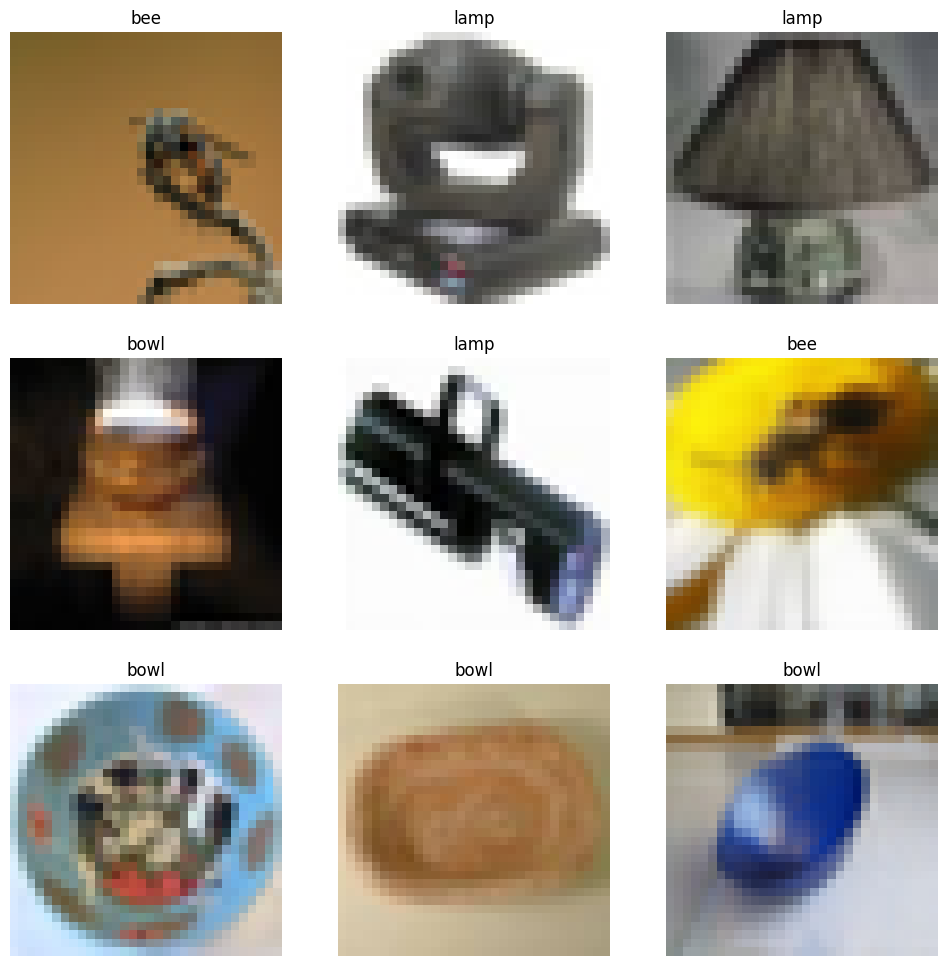

In [10]:
import matplotlib.pyplot as plt
ROWS = 3
COLS = 3

_, ax = plt.subplots(ROWS, COLS, figsize=(12, 12))

for i in range(9):
    img, label = train_subset[i]

    row_index = int(i / ROWS)
    col_index = i % COLS
    current_plt_cell = ax[row_index, col_index]

    current_plt_cell.imshow(img.permute(1,2,0)) # CHW -> HWC
    current_plt_cell.set_title(train_data.classes[label])
    current_plt_cell.axis('off')

## Предобработка датасетов
Трансформируем исходные названия меток классов на более удобные 0, 1, 2.

In [11]:
from functools import reduce 

def transform_label(label):
    """
    Map initial labels ([6, 10, 40] for example) to simple labels [0, 1, 2].
    """
    for i, initial_label in enumerate(LABELS):
        if label == initial_label:
            return i

    raise ValueError(f'No such label as {label} in ${LABELS}')

def map_labels(labels):
    return map(transform_label, labels)

def compose(f, g):
        return lambda x : f(g(x))

def create_masked_dataset(subset: Subset, dataset: TensorDataset, target_transforms=[lambda x: x]) -> TensorDataset:
    features = [dataset[i][0].numpy() for i in subset.indices]
    tensor_features = torch.tensor(features)

    targets = [dataset[i][1] for i in subset.indices]

    # Reducing array of transform functions to a compose function.
    # :example: [f, g] -> lambda x: f(g(x))
    composed_target_transforms = reduce(compose, target_transforms, lambda x: x)
    # TODO: make proper transform instead selfmade map.
    tensor_targets = torch.tensor([composed_target_transforms(target) for target in targets])

    return TensorDataset(tensor_features, tensor_targets)

train_masked_dataset = create_masked_dataset(train_subset, train_data, [transform_label])
test_masked_dataset = create_masked_dataset(test_subset, test_data, [transform_label])

C:\Users\ds13\AppData\Local\Temp\ipykernel_33524\499765724.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  tensor_features = torch.tensor(features)


## Создание DataLoader'а
### Гиперпараметры

In [12]:
LEARNING_RATE = 2.5e-3
EPOCHS = 500

data_loader_settings = {
    'batch_size': 128,
    'shuffle': True,
}

### Pytorch DataLoader

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_masked_dataset, **data_loader_settings)

test_dataloader = DataLoader(test_masked_dataset, **data_loader_settings)

## Создание модели нейронной сети

In [14]:
import torch.nn as nn

IMAGE_WITH = 32
IMAGE_HEIGHT = 32
IMAGE_COLORS = 3
INPUT_SIZE = IMAGE_WITH * IMAGE_HEIGHT * IMAGE_COLORS

class Cifar100NeutralNetwork(nn.Module):
    def __init__(self, hidden_size=10, num_classes=3):
        super(Cifar100NeutralNetwork, self).__init__()

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(INPUT_SIZE, hidden_size), # Сумматор.
            nn.ReLU(), # Функция активации.
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

In [15]:
model = Cifar100NeutralNetwork(hidden_size=10, num_classes=len(LABELS))

## Обучение модели
Прежде чем обучать модель, выберем функцию потерь и оптимизатор.

In [16]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
  """
  Обучающий цикл оптимизации параметров
  """
  size = len(dataloader.dataset)
  for batch, (X,y) in enumerate(dataloader):
    # Расчёт предсказаний и ошибок
    pred = model(X)
    loss = loss_fn(pred, y)

    # Обратное распространение ошибки
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%5 == 0:
      loss, current = loss.item(), batch*len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
  """
  Тестовый цикл оптимизации параметров
  """
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Тестовая ошибка: \n Точность: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

for t in range(EPOCHS):
    print(f"Эпоха {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    print("Готово!")

Эпоха 1
-------------------------------
loss: 1.163483  [    0/ 1500]
loss: 1.096808  [  640/ 1500]
loss: 1.102193  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 40.0%, Avg loss: 1.091670 

Готово!
Эпоха 2
-------------------------------
loss: 1.103774  [    0/ 1500]
loss: 1.091179  [  640/ 1500]
loss: 1.085996  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 46.0%, Avg loss: 1.070127 

Готово!
Эпоха 3
-------------------------------
loss: 1.077712  [    0/ 1500]
loss: 1.053130  [  640/ 1500]
loss: 1.075812  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 47.3%, Avg loss: 1.063341 

Готово!
Эпоха 4
-------------------------------
loss: 1.054390  [    0/ 1500]
loss: 1.066182  [  640/ 1500]
loss: 1.062467  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 51.3%, Avg loss: 1.044519 

Готово!
Эпоха 5
-------------------------------
loss: 1.042553  [    0/ 1500]
loss: 1.059016  [  640/ 1500]
loss: 1.032803  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 52.0%, Avg loss: 1.028308 

Готово!
Эпоха 6
-----------------

Тестовая ошибка: 
 Точность: 59.3%, Avg loss: 0.892989 

Готово!
Эпоха 46
-------------------------------
loss: 0.858091  [    0/ 1500]
loss: 0.872635  [  640/ 1500]
loss: 0.850142  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 59.7%, Avg loss: 0.876976 

Готово!
Эпоха 47
-------------------------------
loss: 0.827023  [    0/ 1500]
loss: 0.888748  [  640/ 1500]
loss: 0.897293  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 58.7%, Avg loss: 0.880984 

Готово!
Эпоха 48
-------------------------------
loss: 0.840917  [    0/ 1500]
loss: 0.945881  [  640/ 1500]
loss: 0.892455  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 59.3%, Avg loss: 0.863187 

Готово!
Эпоха 49
-------------------------------
loss: 0.840710  [    0/ 1500]
loss: 0.959665  [  640/ 1500]
loss: 0.844784  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 59.7%, Avg loss: 0.875460 

Готово!
Эпоха 50
-------------------------------
loss: 0.905001  [    0/ 1500]
loss: 0.845625  [  640/ 1500]
loss: 0.835372  [ 1280/ 1500]
Тестовая ошибка: 
 Т

loss: 0.738695  [  640/ 1500]
loss: 0.736395  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 60.0%, Avg loss: 0.866357 

Готово!
Эпоха 89
-------------------------------
loss: 0.785246  [    0/ 1500]
loss: 0.826410  [  640/ 1500]
loss: 0.796076  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 60.3%, Avg loss: 0.830094 

Готово!
Эпоха 90
-------------------------------
loss: 0.770607  [    0/ 1500]
loss: 0.823313  [  640/ 1500]
loss: 0.817789  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 60.7%, Avg loss: 0.851578 

Готово!
Эпоха 91
-------------------------------
loss: 0.768585  [    0/ 1500]
loss: 0.782901  [  640/ 1500]
loss: 0.818912  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 61.3%, Avg loss: 0.851385 

Готово!
Эпоха 92
-------------------------------
loss: 0.766228  [    0/ 1500]
loss: 0.790946  [  640/ 1500]
loss: 0.802746  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 60.0%, Avg loss: 0.854464 

Готово!
Эпоха 93
-------------------------------
loss: 0.828377  [    0/ 1500]
loss: 0.796706  [  6

loss: 0.754748  [  640/ 1500]
loss: 0.778390  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 59.7%, Avg loss: 0.809355 

Готово!
Эпоха 131
-------------------------------
loss: 0.692379  [    0/ 1500]
loss: 0.805448  [  640/ 1500]
loss: 0.834783  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 60.0%, Avg loss: 0.821112 

Готово!
Эпоха 132
-------------------------------
loss: 0.662017  [    0/ 1500]
loss: 0.808677  [  640/ 1500]
loss: 0.768823  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 60.0%, Avg loss: 0.817348 

Готово!
Эпоха 133
-------------------------------
loss: 0.660043  [    0/ 1500]
loss: 0.816391  [  640/ 1500]
loss: 0.690835  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 59.3%, Avg loss: 0.807941 

Готово!
Эпоха 134
-------------------------------
loss: 0.826681  [    0/ 1500]
loss: 0.786661  [  640/ 1500]
loss: 0.684169  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 60.3%, Avg loss: 0.805224 

Готово!
Эпоха 135
-------------------------------
loss: 0.803945  [    0/ 1500]
loss: 0.793962 

loss: 0.763527  [  640/ 1500]
loss: 0.702264  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 60.7%, Avg loss: 0.806091 

Готово!
Эпоха 177
-------------------------------
loss: 0.767946  [    0/ 1500]
loss: 0.695504  [  640/ 1500]
loss: 0.693840  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 60.3%, Avg loss: 0.760209 

Готово!
Эпоха 178
-------------------------------
loss: 0.746027  [    0/ 1500]
loss: 0.680377  [  640/ 1500]
loss: 0.695241  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 60.3%, Avg loss: 0.794848 

Готово!
Эпоха 179
-------------------------------
loss: 0.798189  [    0/ 1500]
loss: 0.788376  [  640/ 1500]
loss: 0.691905  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 61.0%, Avg loss: 0.773978 

Готово!
Эпоха 180
-------------------------------
loss: 0.744161  [    0/ 1500]
loss: 0.735323  [  640/ 1500]
loss: 0.692227  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 60.7%, Avg loss: 0.808308 

Готово!
Эпоха 181
-------------------------------
loss: 0.822386  [    0/ 1500]
loss: 0.711411 

Тестовая ошибка: 
 Точность: 63.0%, Avg loss: 0.780922 

Готово!
Эпоха 220
-------------------------------
loss: 0.707671  [    0/ 1500]
loss: 0.763956  [  640/ 1500]
loss: 0.687991  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 62.3%, Avg loss: 0.778528 

Готово!
Эпоха 221
-------------------------------
loss: 0.668141  [    0/ 1500]
loss: 0.659666  [  640/ 1500]
loss: 0.738033  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 64.3%, Avg loss: 0.782388 

Готово!
Эпоха 222
-------------------------------
loss: 0.702605  [    0/ 1500]
loss: 0.736181  [  640/ 1500]
loss: 0.710448  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 62.3%, Avg loss: 0.767865 

Готово!
Эпоха 223
-------------------------------
loss: 0.684128  [    0/ 1500]
loss: 0.630719  [  640/ 1500]
loss: 0.712328  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 62.7%, Avg loss: 0.773388 

Готово!
Эпоха 224
-------------------------------
loss: 0.731449  [    0/ 1500]
loss: 0.703433  [  640/ 1500]
loss: 0.672017  [ 1280/ 1500]
Тестовая ошибка

loss: 0.667761  [  640/ 1500]
loss: 0.705057  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 64.3%, Avg loss: 0.746549 

Готово!
Эпоха 266
-------------------------------
loss: 0.709285  [    0/ 1500]
loss: 0.781183  [  640/ 1500]
loss: 0.700374  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 65.3%, Avg loss: 0.733332 

Готово!
Эпоха 267
-------------------------------
loss: 0.646670  [    0/ 1500]
loss: 0.652552  [  640/ 1500]
loss: 0.601987  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 65.0%, Avg loss: 0.793436 

Готово!
Эпоха 268
-------------------------------
loss: 0.606587  [    0/ 1500]
loss: 0.626775  [  640/ 1500]
loss: 0.685679  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 64.7%, Avg loss: 0.763099 

Готово!
Эпоха 269
-------------------------------
loss: 0.707627  [    0/ 1500]
loss: 0.640130  [  640/ 1500]
loss: 0.655596  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 66.7%, Avg loss: 0.754859 

Готово!
Эпоха 270
-------------------------------
loss: 0.681879  [    0/ 1500]
loss: 0.770874 

loss: 0.679111  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 65.0%, Avg loss: 0.738619 

Готово!
Эпоха 312
-------------------------------
loss: 0.675139  [    0/ 1500]
loss: 0.602815  [  640/ 1500]
loss: 0.747060  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 65.7%, Avg loss: 0.740456 

Готово!
Эпоха 313
-------------------------------
loss: 0.651486  [    0/ 1500]
loss: 0.664705  [  640/ 1500]
loss: 0.627105  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 66.7%, Avg loss: 0.773503 

Готово!
Эпоха 314
-------------------------------
loss: 0.592785  [    0/ 1500]
loss: 0.700649  [  640/ 1500]
loss: 0.710074  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 66.0%, Avg loss: 0.734498 

Готово!
Эпоха 315
-------------------------------
loss: 0.608366  [    0/ 1500]
loss: 0.732639  [  640/ 1500]
loss: 0.705048  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 67.3%, Avg loss: 0.735375 

Готово!
Эпоха 316
-------------------------------
loss: 0.551486  [    0/ 1500]
loss: 0.702602  [  640/ 1500]
loss: 0.601141 

loss: 0.635930  [  640/ 1500]
loss: 0.645599  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 68.7%, Avg loss: 0.734625 

Готово!
Эпоха 354
-------------------------------
loss: 0.691755  [    0/ 1500]
loss: 0.688005  [  640/ 1500]
loss: 0.535956  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 67.7%, Avg loss: 0.746020 

Готово!
Эпоха 355
-------------------------------
loss: 0.576300  [    0/ 1500]
loss: 0.657569  [  640/ 1500]
loss: 0.700472  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 68.3%, Avg loss: 0.734606 

Готово!
Эпоха 356
-------------------------------
loss: 0.598285  [    0/ 1500]
loss: 0.632427  [  640/ 1500]
loss: 0.610865  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 68.7%, Avg loss: 0.741658 

Готово!
Эпоха 357
-------------------------------
loss: 0.729621  [    0/ 1500]
loss: 0.578019  [  640/ 1500]
loss: 0.597851  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 68.3%, Avg loss: 0.751419 

Готово!
Эпоха 358
-------------------------------
loss: 0.535462  [    0/ 1500]
loss: 0.642805 

loss: 0.669792  [  640/ 1500]
loss: 0.570363  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 70.0%, Avg loss: 0.729770 

Готово!
Эпоха 399
-------------------------------
loss: 0.637112  [    0/ 1500]
loss: 0.632867  [  640/ 1500]
loss: 0.587878  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 70.0%, Avg loss: 0.721013 

Готово!
Эпоха 400
-------------------------------
loss: 0.608255  [    0/ 1500]
loss: 0.675414  [  640/ 1500]
loss: 0.544941  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 69.7%, Avg loss: 0.730489 

Готово!
Эпоха 401
-------------------------------
loss: 0.567918  [    0/ 1500]
loss: 0.550869  [  640/ 1500]
loss: 0.576637  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 69.3%, Avg loss: 0.717434 

Готово!
Эпоха 402
-------------------------------
loss: 0.561729  [    0/ 1500]
loss: 0.527974  [  640/ 1500]
loss: 0.589374  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 68.3%, Avg loss: 0.731577 

Готово!
Эпоха 403
-------------------------------
loss: 0.651769  [    0/ 1500]
loss: 0.581288 

loss: 0.599149  [  640/ 1500]
loss: 0.553869  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 68.0%, Avg loss: 0.708604 

Готово!
Эпоха 443
-------------------------------
loss: 0.626979  [    0/ 1500]
loss: 0.582732  [  640/ 1500]
loss: 0.622916  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 68.3%, Avg loss: 0.769699 

Готово!
Эпоха 444
-------------------------------
loss: 0.656337  [    0/ 1500]
loss: 0.573840  [  640/ 1500]
loss: 0.617109  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 70.3%, Avg loss: 0.729945 

Готово!
Эпоха 445
-------------------------------
loss: 0.595588  [    0/ 1500]
loss: 0.657746  [  640/ 1500]
loss: 0.562049  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 70.0%, Avg loss: 0.714212 

Готово!
Эпоха 446
-------------------------------
loss: 0.605965  [    0/ 1500]
loss: 0.597117  [  640/ 1500]
loss: 0.587934  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 69.0%, Avg loss: 0.715498 

Готово!
Эпоха 447
-------------------------------
loss: 0.519592  [    0/ 1500]
loss: 0.534325 

loss: 0.535984  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 70.0%, Avg loss: 0.718940 

Готово!
Эпоха 485
-------------------------------
loss: 0.557786  [    0/ 1500]
loss: 0.598960  [  640/ 1500]
loss: 0.590780  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 69.7%, Avg loss: 0.731731 

Готово!
Эпоха 486
-------------------------------
loss: 0.551972  [    0/ 1500]
loss: 0.592276  [  640/ 1500]
loss: 0.601754  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 69.3%, Avg loss: 0.737258 

Готово!
Эпоха 487
-------------------------------
loss: 0.610805  [    0/ 1500]
loss: 0.567891  [  640/ 1500]
loss: 0.656115  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 69.7%, Avg loss: 0.770404 

Готово!
Эпоха 488
-------------------------------
loss: 0.544574  [    0/ 1500]
loss: 0.587693  [  640/ 1500]
loss: 0.546471  [ 1280/ 1500]
Тестовая ошибка: 
 Точность: 70.7%, Avg loss: 0.730893 

Готово!
Эпоха 489
-------------------------------
loss: 0.528672  [    0/ 1500]
loss: 0.585133  [  640/ 1500]
loss: 0.475938 

## Сохранение модели и экспорт в ONNX

In [18]:
MODEL_ROOT = 'model_result_data'
MODEL_NAME = 'cifar100'

torch.save(model, f'{MODEL_ROOT}/{MODEL_NAME}.pt')

# Экспорт модели
x = torch.randn(1, IMAGE_WITH, IMAGE_HEIGHT, IMAGE_COLORS, requires_grad=True).to('cpu')

torch.onnx.export(model,               
                  x,                   
                  f'{MODEL_ROOT}/{MODEL_NAME}.onnx', 
                  export_params=True,
                  opset_version=9,     
                  do_constant_folding=True,  
                  input_names = ['input'],  
                  output_names = ['output'],  
                  dynamic_axes={'input' : {0 : 'batch_size'},    
                                'output' : {0 : 'batch_size'}})